In [1]:
#Import Libraries

#for reading and data-manipulation
import os
import numpy as np
import pandas as pd

In [2]:
#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [3]:
#for data preprocessing
import time
from contractions import contractions_dict
import re
from collections import Counter
from wordcloud import STOPWORDS
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# for ML model Implementation
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bertopic import BERTopic
from sklearn.metrics import silhouette_score
import hdbscan
from sentence_transformers import SentenceTransformer
from umap import UMAP

/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# This code avoids printing different warnings in following jupyter cells.
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=SettingWithCopyWarning)


In [6]:
df = pd.read_csv('GlobalNewsDataset/data.csv', encoding='ISO-8859-1')
df.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content
0,89541,NaN,International Business Times,Paavan MATHEMA,UN Chief Urges World To 'Stop The Madness' Of ...,UN Secretary-General Antonio Guterres urged th...,https://www.ibtimes.com/un-chief-urges-world-s...,https://d.ibtimes.com/en/full/4496078/nepals-g...,2023-10-30 10:12:35.000000,UN Secretary-General Antonio Guterres urged th...,Nepal,UN Secretary-General Antonio Guterres urged th...
1,89542,NaN,Prtimes.jp,NaN,RANDEBOOããã¯ã³ã©ã³ã¯ä¸ã®å¤§äººã£ã...,[æ ªå¼ä¼ç¤¾Ainer]\nRANDEBOOï¼ã©ã³ããã...,https://prtimes.jp/main/html/rd/p/000000147.00...,https://prtimes.jp/i/32220/147/ogp/d32220-147-...,2023-10-06 04:40:02.000000,"RANDEBOO2023718()WEB2023 Autumn Winter \n""Nepa...",Nepal,NaN
2,89543,NaN,VOA News,webdesk@voanews.com (Agence France-Presse),UN Chief Urges World to 'Stop the Madness' of ...,UN Secretary-General Antonio Guterres urged th...,https://www.voanews.com/a/un-chief-urges-world...,https://gdb.voanews.com/01000000-0a00-0242-60f...,2023-10-30 10:53:30.000000,"Kathmandu, Nepal Â UN Secretary-General Antoni...",Nepal,NaN
3,89545,NaN,The Indian Express,Editorial,Sikkim warning: Hydroelectricity push must be ...,Ecologists caution against the adverse effects...,https://indianexpress.com/article/opinion/edit...,https://images.indianexpress.com/2023/10/edit-...,2023-10-06 01:20:24.000000,At least 14 persons lost their lives and more ...,Nepal,At least 14 persons lost their lives and more ...
4,89547,NaN,The Times of Israel,Jacob Magid,"200 foreigners, dual nationals cut down in Ham...","France lost 35 citizens, Thailand 33, US 31, U...",https://www.timesofisrael.com/200-foreigners-d...,https://static.timesofisrael.com/www/uploads/2...,2023-10-27 01:08:34.000000,"Scores of foreign citizens were killed, taken ...",Nepal,NaN


In [7]:
df.category.value_counts().iloc[0:20]

category
Stock          3999
Health         2594
Finance        2402
Technology     2371
Real estate    2352
Canada         2324
News           1852
COVID          1821
Education      1771
Food           1613
Jobs           1562
Weather        1496
Travel         1451
Cars           1289
Science        1261
Asia           1242
India          1196
Music          1159
Politics       1156
Climate        1140
Name: count, dtype: int64

In [8]:
# Define the list of categories you want to keep
categories_to_keep = ['Stock', 'Health', 'Finance', 'Technology', 'Real estate', 'COVID', 
                      'Education', 'Food', 'Jobs', 'Weather', 'Travel', 'Cars', 
                      'Science', 'Music', 'Politics', 'Climate']

# Filter the dataframe to keep only the records with the desired categories
df_filtered = df[df['category'].isin(categories_to_keep)]

# Verify the filtered data
df_filtered['category'].value_counts()


category
Stock          3999
Health         2594
Finance        2402
Technology     2371
Real estate    2352
COVID          1821
Education      1771
Food           1613
Jobs           1562
Weather        1496
Travel         1451
Cars           1289
Science        1261
Music          1159
Politics       1156
Climate        1140
Name: count, dtype: int64

In [9]:
df = df_filtered.rename(columns={'article_id': 'unique_identifier', 'content': 'brief_review'})

In [10]:
df = df[['unique_identifier', 'brief_review', 'category']].dropna()

In [11]:
# Handling missing values
df.isnull().sum()

unique_identifier    0
brief_review         0
category             0
dtype: int64

In [12]:
#handling duplicate values 
len(df[df.duplicated(subset=['brief_review'])])

2952

In [13]:
# Drop duplicate 
df_cleaned = df.drop_duplicates(subset = ["brief_review"])
print(df_cleaned.head())

      unique_identifier                                       brief_review  \
556               95201  <ul><li>Samia says the two nations will addres...   
961               96533  Environmental Defenders Face Harassment, Intim...   
1280              93416  WeWork has seen a dramatic fall from grace sin...   
1289              93553  Orlando real estate agent and content creator ...   
1393             105026  Piers, Roxie, and Ryuki rock Pasio with a publ...   

         category  
556      Politics  
961       Climate  
1280  Real estate  
1289  Real estate  
1393      Weather  


In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26485 entries, 556 to 104690
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   unique_identifier  26485 non-null  int64 
 1   brief_review       26485 non-null  object
 2   category           26485 non-null  object
dtypes: int64(1), object(2)
memory usage: 827.7+ KB


In [15]:
# Expand Contraction

# Function to expand contractions using the contractions_dict
def expand_contractions(text):
    # Regular expression pattern to match contractions
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        expanded = contractions_dict.get(match.lower())
        return expanded

    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text

# Apply the expand_contractions function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(expand_contractions)

In [16]:
# Remove Punctuations

# Function to remove punctuations from text
def remove_punctuations(text):
    # Create a translation table to remove punctuations
    translator = str.maketrans('', '', string.punctuation +'\n')

    # Apply the translation table to remove punctuations
    text_without_punctuations = text.translate(translator)
    return text_without_punctuations

# Apply the remove_punctuations function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_punctuations)

In [17]:
# Convert text in the "brief_review" column to lowercase
df_cleaned['brief_review'] = df_cleaned['brief_review'].str.lower()

In [18]:
# Function to remove URLs from text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return re.sub(url_pattern, '', text)

# Function to remove words containing digits from text
def remove_words_with_digits(text):
    return ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))

# Function to remove non-ASCII characters (special characters)
def remove_special_characters(text):
    # Replace non-ASCII characters with a space
    return re.sub(r'[^\x00-\x7F]+', ' ', text)

# Apply the remove_urls function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_urls)

# Apply the remove_words_with_digits function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_words_with_digits)

# Apply the remove_special_characters function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_special_characters)

# Verify the cleaned data
df_cleaned['brief_review'].head()


556     ullisamia says the two nations will address sh...
961     environmental defenders face harassment intimi...
1280    wework has seen a dramatic fall from grace sin...
1289    orlando real estate agent and content creator ...
1393    piers roxie and ryuki rock pasio with a public...
Name: brief_review, dtype: object

In [19]:
 # Remove Stopwords
# Download the list of stopwords if not already downloaded
nltk.download('stopwords')

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Add unnecessary words to the list of English stopwords
stop_unnecessary_words = stop_words.union(set(['mr', 'people', 'would', 'year', 'said', 'say', 'also', 'wale', 'could']))


# Function to remove stopwords from text
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if len(word)>2]
    filtered_words = [word for word in words if word.lower() not in stop_unnecessary_words]
    return ' '.join(filtered_words)

# Apply the remove_stopwords function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/binitkc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Remove white spaces from the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].str.replace('\s+', ' ', regex=True)

In [21]:
# Tokenization

# Download the punkt package
nltk.download('punkt')
# Download the punkt_tab resource as well
nltk.download('punkt_tab')

# Function to tokenize text
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply the tokenize_text function to the "brief_review" column
df_cleaned['tokenized_content'] = df_cleaned['brief_review'].apply(tokenize_text)


[nltk_data] Downloading package punkt to /Users/binitkc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/binitkc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [22]:
df_cleaned.head()

,unique_identifier,brief_review,category,tokenized_content
556,95201,ullisamia says two nations address shared colo...,Politics,"[ullisamia, says, two, nations, address, share..."
961,96533,environmental defenders face harassment intimi...,Climate,"[environmental, defenders, face, harassment, i..."
1280,93416,wework seen dramatic fall grace since valued b...,Real estate,"[wework, seen, dramatic, fall, grace, since, v..."
1289,93553,orlando real estate agent content creator fred...,Real estate,"[orlando, real, estate, agent, content, creato..."
1393,105026,piers roxie ryuki rock pasio public jam sessio...,Weather,"[piers, roxie, ryuki, rock, pasio, public, jam..."


In [23]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to perform stemming on text
def stem_text(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Apply the stem_text function to the "tokenized_content" column
df_cleaned['stemmed_content'] = df_cleaned['tokenized_content'].apply(stem_text)

In [24]:
nltk.download('wordnet')
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization on text
def lemmatize_text(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Apply the lemmatize_text function to the "tokenized_content" column
df_cleaned['lemmatized_content'] = df_cleaned['tokenized_content'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /Users/binitkc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
df_cleaned['lemmatized_content'].info()

<class 'pandas.core.series.Series'>
Index: 26485 entries, 556 to 104690
Series name: lemmatized_content
Non-Null Count  Dtype 
--------------  ----- 
26485 non-null  object
dtypes: object(1)
memory usage: 413.8+ KB


In [26]:
df_cleaned = df_cleaned.iloc[0:10000]

In [27]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 556 to 55850
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   unique_identifier   10000 non-null  int64 
 1   brief_review        10000 non-null  object
 2   category            10000 non-null  object
 3   tokenized_content   10000 non-null  object
 4   stemmed_content     10000 non-null  object
 5   lemmatized_content  10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 546.9+ KB


In [31]:
# ML Model - 1 Implementation

# Convert the list of lemmatized tokens into a list of lists
lemmatized_text = [tokens for tokens in df_cleaned['lemmatized_content']]

# Create a dictionary of terms with term frequency filtering
dictionary = corpora.Dictionary(lemmatized_text)
dictionary.filter_extremes(no_below=3, no_above=0.85)

# Fit the Algorithm

# Create a Gensim corpus
corpus_gensim = [dictionary.doc2bow(text) for text in lemmatized_text]

# Build LDA model
num_topics = 5
lda_model = LdaModel(corpus_gensim, num_topics=num_topics, id2word=dictionary, passes=20, random_state= 40)

print('\n')
print('\n')
# Calculate coherence score
coherence_model = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print coherence score
print(f"Coherence Score: {coherence_score:.4f}")


# Print topics and associated words
for topic_id, topic_words in lda_model.print_topics():
    print('\n')
    print(f"Topic {topic_id}: {topic_words}")

/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Coherence Score: 0.3111


Topic 0: 0.012*"new" + 0.010*"apple" + 0.009*"one" + 0.008*"music" + 0.007*"time" + 0.006*"first" + 0.006*"week" + 0.005*"world" + 0.005*"last" + 0.004*"year"


Topic 1: 0.012*"president" + 0.010*"former" + 0.008*"trump" + 0.007*"case" + 0.007*"product" + 0.006*"house" + 0.006*"minister" + 0.006*"state" + 0.006*"expert" + 0.006*"thursday"


Topic 2: 0.006*"car" + 0.006*"new" + 0.005*"may" + 0.005*"travel" + 0.005*"like" + 0.005*"rate" + 0.005*"one" + 0.005*"food" + 0.005*"climate" + 0.005*"industry"


Topic 3: 0.030*"report" + 0.018*"company" + 0.016*"free" + 0.015*"share" + 0.011*"inc" + 0.011*"quarter" + 0.010*"according" + 0.009*"stock" + 0.009*"november" + 0.008*"global"


Topic 4: 0.011*"new" + 0.008*"city" + 0.007*"state" + 0.007*"israel" + 0.006*"gaza" + 0.006*"million" + 0.005*"two" + 0.005*"united" + 0.005*"country" + 0.004*"york"


In [32]:
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import ParameterGrid
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel

# Define a grid of hyperparameters to search over
param_grid = {
    'num_topics': [3, 4, 5, 6, 7, 8],
    'passes': [10,15,20,25]
}

best_coherence_score = -1
best_lda_model = None
scores = []  # To store coherence scores
topics = []  # To store number of topics
passes_list = []  # To store passes for each model

# Perform grid search
for params in ParameterGrid(param_grid):
    lda_model = LdaModel(corpus=corpus_gensim, id2word=dictionary, **params)
    coherence_model = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Track best model
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_lda_model = lda_model
    
    # Collect data for plotting
    scores.append(coherence_score)
    topics.append(params['num_topics'])
    passes_list.append(params['passes'])


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

In [34]:
# After grid search is completed and best_lda_model is chosen:
best_lda_model.save("Trained_models/lda_news.model")

# Optionally, print confirmation
print(" LDA_news model saved successfully! ")

 LDA_news model saved successfully! 


In [35]:
# Load the saved model
best_lda_model = LdaModel.load("Trained_models/lda_news.model")

# Optionally, print to confirm successful loading
print("LDA model loaded successfully!")

LDA model loaded successfully!


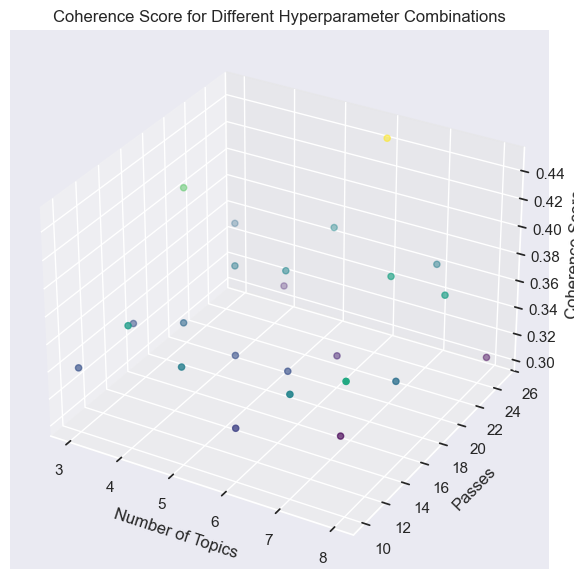

Best Hyperparameters: LdaModel<num_terms=8085, num_topics=6, decay=0.5, chunksize=2000>
Best Coherence Score: 0.4464

Topic 0: 0.019*"recent" + 0.016*"according" + 0.016*"report" + 0.013*"free" + 0.012*"company" + 0.011*"quarter" + 0.011*"inc" + 0.011*"trump" + 0.009*"new" + 0.009*"former"

Topic 1: 0.014*"company" + 0.013*"november" + 0.010*"global" + 0.010*"today" + 0.009*"globe" + 0.008*"newswire" + 0.007*"announced" + 0.007*"quarter" + 0.007*"sale" + 0.007*"million"

Topic 2: 0.034*"report" + 0.015*"free" + 0.015*"stock" + 0.015*"share" + 0.014*"get" + 0.011*"research" + 0.009*"issued" + 0.009*"earnings" + 0.009*"thursday" + 0.008*"mber"

Topic 3: 0.009*"state" + 0.009*"health" + 0.009*"job" + 0.009*"new" + 0.007*"rate" + 0.006*"government" + 0.005*"federal" + 0.005*"school" + 0.005*"ber" + 0.005*"month"

Topic 4: 0.013*"new" + 0.009*"product" + 0.006*"may" + 0.006*"commission" + 0.006*"case" + 0.006*"expert" + 0.005*"like" + 0.005*"receive" + 0.005*"industry" + 0.005*"question"

T

In [33]:
# # Plot coherence score in 3D
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(topics, passes_list, scores, c=scores, cmap='viridis', marker='o')
# ax.set_xlabel('Number of Topics')
# ax.set_ylabel('Passes')
# ax.set_zlabel('Coherence Score')
# ax.set_title("Coherence Score for Different Hyperparameter Combinations")
# plt.show()

# # Print best hyperparameters and coherence score
# print("Best Hyperparameters:", best_lda_model)
# print(f"Best Coherence Score: {best_coherence_score:.4f}")

# # Print topics and associated words for the best model
# for topic_id, topic_words in best_lda_model.print_topics():
#     print(f"\nTopic {topic_id}: {topic_words}")

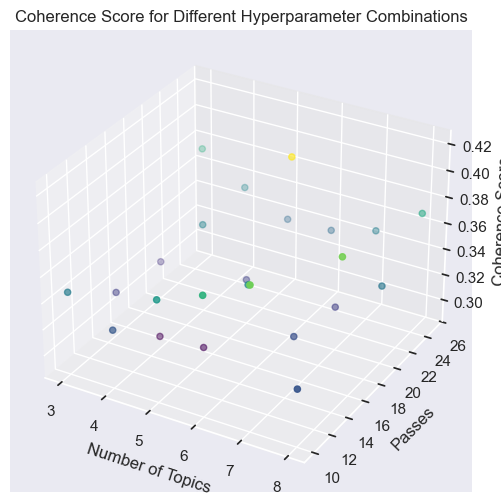

Best Number of Topics: 6
Best Number of Passes: 20
Best Coherence Score: 0.4208

Topic 0: 0.037*"report" + 0.018*"free" + 0.018*"share" + 0.017*"company" + 0.014*"november" + 0.014*"research" + 0.012*"mber" + 0.011*"get" + 0.011*"globe" + 0.011*"today"

Topic 1: 0.010*"music" + 0.009*"new" + 0.008*"one" + 0.007*"first" + 0.006*"like" + 0.006*"time" + 0.005*"day" + 0.005*"year" + 0.005*"world" + 0.004*"get"

Topic 2: 0.010*"new" + 0.010*"stock" + 0.009*"thursday" + 0.009*"rate" + 0.009*"price" + 0.008*"million" + 0.008*"friday" + 0.007*"trump" + 0.007*"house" + 0.007*"federal"

Topic 3: 0.010*"state" + 0.007*"israel" + 0.007*"gaza" + 0.006*"product" + 0.006*"country" + 0.005*"commission" + 0.005*"president" + 0.005*"new" + 0.005*"student" + 0.005*"university"

Topic 4: 0.013*"new" + 0.008*"apple" + 0.008*"car" + 0.008*"one" + 0.007*"job" + 0.006*"time" + 0.004*"year" + 0.004*"watch" + 0.004*"ceo" + 0.004*"season"

Topic 5: 0.016*"according" + 0.016*"company" + 0.013*"recent" + 0.013*"re

In [38]:
# Plot coherence score in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(topics, passes_list, scores, c=scores, cmap='viridis', marker='o')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Passes')
ax.set_zlabel('Coherence Score')
ax.set_title("Coherence Score for Different Hyperparameter Combinations")
plt.show()

# Find the best hyperparameters and coherence score
best_index = scores.index(max(scores))  # Get the index of the best score
best_topics = topics[best_index]
best_passes = passes_list[best_index]
best_coherence_score = scores[best_index]

# Print best hyperparameters and coherence score
print("Best Number of Topics:", best_topics)
print("Best Number of Passes:", best_passes)
print(f"Best Coherence Score: {best_coherence_score:.4f}")

# Print topics and associated words for the best model
for topic_id, topic_words in best_lda_model.print_topics():
    print(f"\nTopic {topic_id}: {topic_words}")


In [43]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_topic_diversity(lda_model, num_topics):
    # Get the topic-word distributions from the LDA model
    topic_word_distributions = [lda_model.get_topics()[i] for i in range(num_topics)]
    
    # Calculate pairwise cosine similarities between topics
    similarities = cosine_similarity(topic_word_distributions)
    
    # Set diagonal elements to zero (similarity of a topic with itself should not be counted)
    np.fill_diagonal(similarities, 0)
    
    # Calculate topic diversity (1 - average cosine similarity)
    avg_similarity = np.mean(similarities)
    topic_diversity = 1 - avg_similarity
    
    return topic_diversity

# Assuming 'best_lda_model' is the trained model and 'num_topics' is the number of topics
topic_diversity = calculate_topic_diversity(best_lda_model, best_lda_model.num_topics)

print(f"Topic Diversity: {topic_diversity:.4f}")


Topic Diversity: 0.8142


In [49]:
lda_model = best_lda_model

In [50]:
# Visualize the topics
vis_data = gensimvis.prepare(lda_model, corpus_gensim, dictionary)
pyLDAvis.display(vis_data)

In [29]:
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
# import numpy as np

# Step 1: Prepare text data
# Assuming 'lemmatized_text' is a list of lists of lemmatized tokens as per your previous code
lemmatized_text = [tokens for tokens in df_cleaned['lemmatized_content']]

# Step 2: Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_text)

# Step 3: Train LSA model using TruncatedSVD
num_topics = 5
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

# Step 4: Extract top words for each topic
def get_lsa_topics(model, vectorizer, n_words=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_words_indices = topic.argsort()[:-n_words - 1:-1]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_indices]
        topics.append(top_words)
    return topics

topics = get_lsa_topics(lsa_model, tfidf_vectorizer)

# Step 5: Create a Gensim dictionary and corpus for coherence calculation
dictionary = Dictionary(lemmatized_text)
corpus = [dictionary.doc2bow(text) for text in lemmatized_text]

# Step 6: Calculate the coherence score
coherence_model = CoherenceModel(topics=topics, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print coherence score
print(f"Coherence Score: {coherence_score:.4f}")

# Display the topics and their associated words
for i, topic in enumerate(topics):
    print(f"Topic {i}: {', '.join(topic)}")


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Coherence Score: 0.8213
Topic 0: report, char, free, share, quarter, company, inc, according, recent, new
Topic 1: char, product, commission, receive, expert, case, answer, question, unbiased, review
Topic 2: product, receive, commission, expert, unbiased, assess, case, write, reader, answer
Topic 3: report, global, newswire, globe, november, research, issued, get, earnings, analyst
Topic 4: november, globe, newswire, global, dublin, according, added, size, forecast, researchandetscoms


In [31]:
# import matplotlib.pyplot as plt

# Parameters
num_top_words = 7  # Number of top words to display for each topic
num_topics = lda_model.num_topics  # Total number of topics in the LDA model

# Define grid size for plotting (adjust based on the number of topics)
num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Plot the top words for each topic
for topic_idx in range(num_topics):
    row = topic_idx // num_cols
    col = topic_idx % num_cols

    # Get the top words and weights for the current topic
    top_words = lda_model.show_topic(topic_idx, topn=num_top_words)
    words, weights = zip(*top_words)

    # Plot horizontal bar chart for the topic
    axes[row, col].barh(words, weights, color='skyblue')
    axes[row, col].set_title(f"Top {num_top_words} Words for Topic {topic_idx}")
    axes[row, col].set_xlabel("Word Importance")
    axes[row, col].invert_yaxis()  # Show the most important word at the top

# Remove empty subplots if the grid is larger than the number of topics
for i in range(num_topics, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


NameError: name 'lda_model' is not defined

In [32]:

# Step 1: Prepare text data
lemmatized_text = [tokens for tokens in df_cleaned['lemmatized_content']]

# Step 2: Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_text)

# Function to extract top words for each topic
def get_lsa_topics(model, vectorizer, n_words=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_words_indices = topic.argsort()[:-n_words - 1:-1]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_indices]
        topics.append(top_words)
    return topics

# Step 3: Hyperparameter tuning
topic_range = [2, 3, 5, 6, 7, 10, 15]  # Range of topic numbers to evaluate
best_coherence_score = -1
best_num_topics = None
best_lsa_model = None
best_topics = None

# Create a Gensim dictionary and corpus
dictionary = Dictionary(lemmatized_text)
corpus = [dictionary.doc2bow(text) for text in lemmatized_text]

for num_topics in topic_range:
    # Train LSA model
    lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
    lsa_model.fit(tfidf_matrix)
    
    # Extract topics
    topics = get_lsa_topics(lsa_model, tfidf_vectorizer)
    
    # Calculate coherence score
    coherence_model = CoherenceModel(topics=topics, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")
    
    # Update the best model if the coherence score improves
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_num_topics = num_topics
        best_lsa_model = lsa_model
        best_topics = topics

# Display the best coherence score and the corresponding number of topics
print(f"\nBest Coherence Score: {best_coherence_score:.4f} with {best_num_topics} topics")

# Display the topics and their associated words for the best model
print("\nBest Topics:")
for i, topic in enumerate(best_topics):
    print(f"Topic {i}: {', '.join(topic)}")


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 2, Coherence Score: 0.8384


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 3, Coherence Score: 0.8909


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 5, Coherence Score: 0.8213


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 6, Coherence Score: 0.7771


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 7, Coherence Score: 0.7989


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 10, Coherence Score: 0.7435


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 15, Coherence Score: 0.6189

Best Coherence Score: 0.8909 with 3 topics

Best Topics:
Topic 0: report, char, free, share, quarter, company, inc, according, recent, new
Topic 1: char, product, commission, expert, receive, case, answer, question, unbiased, review
Topic 2: product, receive, commission, expert, unbiased, assess, case, write, reader, answer


In [33]:
def calculate_topic_diversity(topics, top_n_words=10):
    """
    Calculates topic diversity as the proportion of unique words 
    in the top N words across all topics.
    """
    unique_words = set()
    total_words = 0

    for topic in topics:
        top_words = topic[:top_n_words]
        unique_words.update(top_words)
        total_words += len(top_words)

    topic_diversity = len(unique_words) / total_words
    return topic_diversity

# Calculate topic diversity for the best LSA model
topic_diversity_score = calculate_topic_diversity(best_topics, top_n_words=10)
print(f"\nTopic Diversity: {topic_diversity_score:.4f}")



Topic Diversity: 0.7333
